## Multi Task GANs Implements

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tordata

from torch.autograd import Variable
from torch.autograd import grad
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from network.network_layer import *
from utils.data_load import *
from utils.batch_sampler import *
from utils.functions import *

from datetime import datetime

import multiprocessing as mp

### Settings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 64
hidden_dim = 512

### data

In [4]:
train_dataset, test_dataset = load_OU_ISIR('./data/OU_ISIR/npy/', False)

In [5]:
sampler = BatchSampler(train_dataset, batch_size)

train_loader = tordata.DataLoader(dataset=train_dataset, batch_sampler=sampler, collate_fn=collate_fnn)
test_loader = tordata.DataLoader(dataset=test_dataset)

### model

In [6]:
E = Encoder().to(device)
V = ViewTransformLayer().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

E.weight_init()
V.weight_init()
G.weight_init()
D.weight_init()

### loss & optimizer

In [7]:
criterion_VAC = nn.CrossEntropyLoss()

In [8]:
optim_G = torch.optim.RMSprop([{'params': E.parameters()}, {'params': V.parameters()},
                              {'params': G.parameters()}], lr=5e-5, weight_decay=1.5e-4)
optim_D = torch.optim.RMSprop(D.parameters(), lr=5e-5, weight_decay=1.5e-4)

### train

#### 1. E,V,G,D 

iteration : [100/150000]


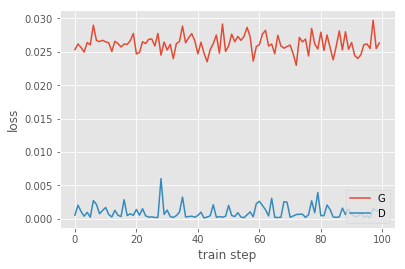

KeyboardInterrupt: 

In [10]:
D_losses = []
G_losses = []

total_iter = 150000
cur_iter = 0

it = iter(train_loader)
while(cur_iter < total_iter):
    for i in range(5):
        
        peis, channel, view, label = it.next()
        
        D.zero_grad()
    
        index = [channel[1][i].index(1) for i in range(len(channel[1]))] 

        input_2 =  Variable(torch.FloatTensor([peis[1][i][j] for i, j in enumerate(index)])).to(device)
        input_1 = Variable(torch.FloatTensor(peis[0])).to(device)  
        input_ch = Variable(torch.FloatTensor(channel)).to(device)
        
        enc_view = encode_view_transform(view[0], view[1]).to(device)

        latent_trans_view = V(E(input_1), enc_view)
        latent_noise = Variable(torch.FloatTensor(np.random.rand(batch_size, hidden_dim)*1e-4)).to(device)
        latent_trans_view += latent_noise

        latent = torch.cat((latent_trans_view, input_ch[0]), 1)

        output_2 = D(input_2)
        input_fake = G(latent)
        output_1 = D(input_fake)

        enc_view_2 = encode_view_onehot(view[1]).to(device)
        enc_label_2 = encode_label_onehot(label[1], list(train_dataset.set_label)).to(device)
        enc_channel_2 = Variable(torch.FloatTensor(channel[1])).to(device)

        flag = torch.cat((enc_view_2, enc_label_2, enc_channel_2), 1)

        loss_D_1 = torch.mean(torch.sum(torch.abs((output_1 - output_2)*flag), 1))

        alpha = torch.rand(batch_size, 1, 1)
        alpha = alpha.expand(input_2.size())
        alpha = Variable(alpha.float()).to(device)

        interpolates = alpha * input_2 + (1-alpha)*input_fake    
        disc_interpolates = torch.mean(torch.sum(D(interpolates)*flag, 1))

        gradients = grad(outputs=disc_interpolates, inputs=interpolates, grad_outputs=torch.ones(disc_interpolates.size()).float().to(device),
                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(-1, 64*64)
        gradients_penalty = ((gradients.norm(2, dim=1) - 1)**2).mean() * 10

        loss_D = loss_D_1 + gradients_penalty
        
        loss_D.backward()
        optim_D.step()
        
    for i in range(1):
        
        peis, channel, view, label = it.next()
        
        E.zero_grad()
        V.zero_grad()
        G.zero_grad()

        latent_trans_view = V(E(input_1), enc_view)
        latent_noise = Variable(torch.FloatTensor(np.random.rand(batch_size, hidden_dim) * 1e-4)).to(device)
        latent_trans_view += latent_noise

        latent = torch.cat((latent_trans_view, input_ch[0]), 1)

        input_fake = G(latent)
        output_1 = D(input_fake)
        
        flag = torch.cat((enc_view_2, enc_label_2, enc_channel_2), 1)

        loss_G_1 = torch.mean(torch.abs(input_2 - input_fake))
        loss_G_2 = torch.mean(torch.sum(-output_1*flag, 1))

        loss_G = loss_G_1 + 1e-5*loss_G_2

        loss_G.backward(retain_graph=True)
        optim_G.step()

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
    if (cur_iter+1) % 100 == 0:
        print('iteration : [{}/{}]'.format(cur_iter+1, total_iter))
        drawLoss({'G':G_losses, 'D':D_losses})
        
    if (cur_iter+1)%200 == 0:
        plt.imshow(input_fake[batch_size-1].detach().cpu().numpy(), cmap='gray')
        plt.savefig("./images/Fake_Images_{}.png".format(cur_iter+1))
        
    cur_iter += 1
    
drawLoss({'G':G_losses, 'D':D_losses})

#### 2. View-angle Classifier

In [ ]:
torch.save(E.state_dict(), os.path.join('./checkpoint/', 'OU_ISIR_E.ptm'))
torch.save(V.state_dict(), os.path.join('./checkpoint/', 'OU_ISIR_V.ptm'))
torch.save(G.state_dict(), os.path.join('./checkpoint/', 'OU_ISIR_G.ptm'))
torch.save(D.state_dict(), os.path.join('./checkpoint/', 'OU_ISIR_D.ptm'))

torch.save(optim_G.state_dict(), os.path.join('./checkpoint/', 'OU_ISIR_Optim_G.ptm'))
torch.save(optim_D.state_dict(), os.path.join('./checkpoint/', 'OU_ISIR_Optim_D.ptm'))

In [9]:
E.load_state_dict(torch.load('./checkpoint/OU_ISIR_E.ptm'))
V.load_state_dict(torch.load('./checkpoint/OU_ISIR_V.ptm'))
G.load_state_dict(torch.load('./checkpoint/OU_ISIR_G.ptm'))
D.load_state_dict(torch.load('./checkpoint/OU_ISIR_D.ptm'))

optim_G.load_state_dict(torch.load('./checkpoint/OU_ISIR_Optim_G.ptm'))
optim_D.load_state_dict(torch.load('./checkpoint/OU_ISIR_Optim_D.ptm'))